# COVID-19の世界の状況を中心に可視化
> COVID-19の世界の状況を中心に可視化

- toc: true 
- badges: true
- comments: true
- categories: [jupyter, COVID-19]

## Novel Coronavirus (COVID-19) Cases, provided by JHU CSSE
グローバール規模だと個別のケースデータは見つからず

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

In [1]:
import pandas as pd
import altair as alt
import requests
import io

URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

r = requests.get(URL)
df = pd.read_csv(io.BytesIO(r.content), sep=",")
df = df.drop(['Province/State', 'Province/State', 'Country/Region', 'Lat', 'Long'], axis='columns')
df = df.sum()
df = pd.DataFrame(df)
df.columns = ['num']
df

,num
1/22/20,555
1/23/20,654
1/24/20,941
1/25/20,1434
1/26/20,2118
...,...
3/18/20,214911
3/19/20,242708
3/20/20,272166
3/21/20,304521


In [2]:
alt.Chart(df.reset_index()).mark_line().encode(
    x='index:T',
    y='num:Q',
)

alt.Chart(...)

## ダッシュボード

ref. https://covid19dashboards.com/covid-overview/


In [2]:
import numpy as np
import pandas as pd
from jinja2 import Template
from IPython.display import HTML

In [3]:
# FETCH
import getpass
base_url = 'https://raw.githubusercontent.com/pratapvardhan/notebooks/master/covid19/'
base_url = '' if (getpass.getuser() == 'Pratap Vardhan') else base_url
paths = {
    'mapping': base_url + 'mapping_countries.csv',
    'overview': base_url + 'overview.tpl'
}

def get_mappings(url):
    df = pd.read_csv(url)
    return {
        'df': df,
        'replace.country': dict(df.dropna(subset=['Name']).set_index('Country')['Name']),
        'map.continent': dict(df.set_index('Name')['Continent'])
    }

mapping = get_mappings(paths['mapping'])

def get_template(path):
    from urllib.parse import urlparse
    if bool(urlparse(path).netloc):
        from urllib.request import urlopen
        return urlopen(path).read().decode('utf8')
    return open(path).read()

def get_frame(name):
    url = (
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
        f'csse_covid_19_time_series/time_series_19-covid-{name}.csv')
    df = pd.read_csv(url)
    # rename countries
    df['Country/Region'] = df['Country/Region'].replace(mapping['replace.country'])
    return df

def get_dates(df):
    dt_cols = df.columns[~df.columns.isin(['Province/State', 'Country/Region', 'Lat', 'Long'])]
    LAST_DATE_I = -1
    # sometimes last column may be empty, then go backwards
    for i in range(-1, -len(dt_cols), -1):
        if not df[dt_cols[i]].fillna(0).eq(0).all():
            LAST_DATE_I = i
            break
    return LAST_DATE_I, dt_cols

In [4]:
COL_REGION = 'Country/Region'
# Confirmed, Recovered, Deaths
df = get_frame('Confirmed')
# dft_: timeseries, dfc_: today country agg
dft_cases = df
dft_deaths = get_frame('Deaths')
dft_recovered = get_frame('Recovered')
LAST_DATE_I, dt_cols = get_dates(df)

dt_today = dt_cols[LAST_DATE_I]
dt_5ago = dt_cols[LAST_DATE_I-5]

dfc_cases = dft_cases.groupby(COL_REGION)[dt_today].sum()
dfc_deaths = dft_deaths.groupby(COL_REGION)[dt_today].sum()
dfc_recovered = dft_recovered.groupby(COL_REGION)[dt_today].sum()
dfp_cases = dft_cases.groupby(COL_REGION)[dt_5ago].sum()
dfp_deaths = dft_deaths.groupby(COL_REGION)[dt_5ago].sum()
dfp_recovered = dft_recovered.groupby(COL_REGION)[dt_5ago].sum()

In [5]:
df_table = (pd.DataFrame(dict(
    Cases=dfc_cases, Deaths=dfc_deaths, Recovered=dfc_recovered,
    PCases=dfp_cases, PDeaths=dfp_deaths, PRecovered=dfp_recovered))
             .sort_values(by=['Cases', 'Deaths'], ascending=[False, False])
             .reset_index())
for c in 'Cases, Deaths, Recovered'.split(', '):
    df_table[f'{c} (+)'] = (df_table[c] - df_table[f'P{c}']).clip(0)  # DATA BUG
df_table['Fatality Rate'] = (100 * df_table['Deaths'] / df_table['Cases']).round(1)
df_table['Continent'] = df_table['Country/Region'].map(mapping['map.continent'])
df_table.head(15)

,Country/Region,Cases,Deaths,Recovered,PCases,PDeaths,PRecovered,Cases (+),Deaths (+),Recovered (+),Fatality Rate,Continent
0,China,81439.0,3274.0,72814.0,81102,3241,69755,337.0,33.0,3059.0,4.0,Asia
1,Italy,59138.0,5476.0,7024.0,35713,2978,4025,23425.0,2498.0,2999.0,9.3,Europe
2,US,33276.0,417.0,178.0,7783,118,0,25493.0,299.0,178.0,1.3,North America
3,Spain,28768.0,1772.0,2575.0,13910,623,1081,14858.0,1149.0,1494.0,6.2,Europe
4,Germany,24873.0,94.0,266.0,12327,28,105,12546.0,66.0,161.0,0.4,Europe
5,Iran,21638.0,1685.0,7931.0,17361,1135,5389,4277.0,550.0,2542.0,7.8,Asia
6,France,16044.0,674.0,2200.0,9105,148,12,6939.0,526.0,2188.0,4.2,Europe
7,South Korea,8897.0,104.0,2909.0,8413,84,1540,484.0,20.0,1369.0,1.2,Asia
8,Switzerland,7245.0,98.0,131.0,3028,28,15,4217.0,70.0,116.0,1.4,Europe
9,United Kingdom,5741.0,282.0,67.0,2642,72,67,3099.0,210.0,0.0,4.9,Europe


In [6]:
# world, china, europe, us
metrics = ['Cases', 'Deaths', 'Recovered', 'Cases (+)', 'Deaths (+)', 'Recovered (+)']
s_china = df_table[df_table['Country/Region'].eq('China')][metrics].sum().add_prefix('China ')
s_us = df_table[df_table['Country/Region'].eq('US')][metrics].sum().add_prefix('US ')
s_eu = df_table[df_table['Continent'].eq('Europe')][metrics].sum().add_prefix('EU ')
summary = {'updated': pd.to_datetime(dt_today), 'since': pd.to_datetime(dt_5ago)}
summary = {**summary, **df_table[metrics].sum(), **s_china, **s_us, **s_eu}
summary

{'updated': Timestamp('2020-03-23 00:00:00'),
 'since': Timestamp('2020-03-18 00:00:00'),
 'Cases': 336004.0,
 'Deaths': 14643.0,
 'Recovered': 98334.0,
 'Cases (+)': 121094.0,
 'Deaths (+)': 5910.0,
 'Recovered (+)': 15139.0,
 'China Cases': 81439.0,
 'China Deaths': 3274.0,
 'China Recovered': 72814.0,
 'China Cases (+)': 337.0,
 'China Deaths (+)': 33.0,
 'China Recovered (+)': 3059.0,
 'US Cases': 33276.0,
 'US Deaths': 417.0,
 'US Recovered': 178.0,
 'US Cases (+)': 25493.0,
 'US Deaths (+)': 299.0,
 'US Recovered (+)': 178.0,
 'EU Cases': 169164.0,
 'EU Deaths': 8807.0,
 'EU Recovered': 12789.0,
 'EU Cases (+)': 78724.0,
 'EU Deaths (+)': 4796.0,
 'EU Recovered (+)': 7351.0}

In [7]:
dft_ct_cases = dft_cases.groupby(COL_REGION)[dt_cols].sum()
dft_ct_new_cases = dft_ct_cases.diff(axis=1).fillna(0).astype(int)
dft_ct_new_cases.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,4,5,5,1,0,0,2,0,16,0
Albania,0,0,0,0,0,0,0,0,0,0,...,5,4,9,4,4,5,6,6,13,0
Algeria,0,0,0,0,0,0,0,0,0,0,...,11,11,6,6,14,13,3,49,62,0
Andorra,0,0,0,0,0,0,0,0,0,0,...,0,0,1,37,0,14,22,13,25,0
Angola,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [8]:
template = Template(get_template(paths['overview']))
html = template.render(
    D=summary, table=df_table,  # REMOVE .head(20) to see all values
    newcases=dft_ct_new_cases.loc[:, dt_cols[LAST_DATE_I-50]:dt_cols[LAST_DATE_I]],
    np=np, pd=pd, enumerate=enumerate)
HTML(f'<div>{html}</div>')

## 増加アニメーション


In [13]:
# essential libraries
import json
import random
from urllib.request import urlopen

# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import folium

# color pallette
cnf = '#393e46' # confirmed - grey
dth = '#ff2e63' # death - red
rec = '#21bf73' # recovered - cyan
act = '#fe9801' # active case - yellow

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# html embedding
from IPython.display import Javascript
from IPython.core.display import display, HTML

In [14]:
# importing datasets
url = 'https://raw.githubusercontent.com/imdevskp/covid_19_jhu_data_web_scrap_and_cleaning/master/covid_19_clean_complete.csv'
full_table = pd.read_csv(url, 
                         parse_dates=['Date'])
full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Thailand,15.0000,101.0000,2020-01-22,2,0,0
1,NaN,Japan,36.0000,138.0000,2020-01-22,2,0,0
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0,0,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0,0,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0,0,0


In [15]:
# cases 
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table[cases] = full_table[cases].fillna(0)

In [16]:
# cases in the ships
ship = full_table[full_table['Province/State'].str.contains('Grand Princess')|full_table['Province/State'].str.contains('Diamond Princess cruise ship')]

# china and the row
china = full_table[full_table['Country/Region']=='China']
row = full_table[full_table['Country/Region']!='China']

# latest
full_latest = full_table[full_table['Date'] == max(full_table['Date'])].reset_index()
china_latest = full_latest[full_latest['Country/Region']=='China']
row_latest = full_latest[full_latest['Country/Region']!='China']

# latest condensed
full_latest_grouped = full_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
china_latest_grouped = china_latest.groupby('Province/State')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
row_latest_grouped = row_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

In [17]:
temp = full_table.groupby(['Country/Region', 'Province/State'])['Confirmed', 'Deaths', 'Recovered', 'Active'].max()
# temp.style.background_gradient(cmap='Reds')

In [18]:
temp = full_table.groupby('Date')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
temp = temp[temp['Date']==max(temp['Date'])].reset_index(drop=True)
temp.style.background_gradient(cmap='Pastel1')

,Date,Confirmed,Deaths,Recovered,Active
0,2020-03-21 00:00:00,304524,12973,91499,200052


In [19]:
# https://app.flourish.studio/visualisation/1571387/edit
HTML('''<div class="flourish-embed flourish-bar-chart-race" data-src="visualisation/1571387"><script src="https://public.flourish.studio/resources/embed.js"></script></div>''')

## 死亡率

ref. https://covid19dashboards.com/covid-19-mortality-estimation/


In [22]:
# Setup and imports
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from IPython.display import display, Markdown

In [23]:
# constants

ignore_countries = [
    'Others',
    'Cruise Ship'
]

cpi_country_mapping = {
    'United States of America': 'US',
    'China': 'Mainland China'
}

wb_country_mapping = {
    'United States': 'US',
    'Egypt, Arab Rep.': 'Egypt',
    'Hong Kong SAR, China': 'Hong Kong',
    'Iran, Islamic Rep.': 'Iran',
    'China': 'Mainland China',
    'Russian Federation': 'Russia',
    'Slovak Republic': 'Slovakia',
    'Korea, Rep.': 'Korea, South'
}

wb_covariates = [
    ('SH.XPD.OOPC.CH.ZS',
        'healthcare_oop_expenditure'),
    ('SH.MED.BEDS.ZS',
        'hospital_beds'),
    ('HD.HCI.OVRL',
        'hci'),
    ('SP.POP.65UP.TO.ZS',
        'population_perc_over65'),
    ('SP.RUR.TOTL.ZS',
        'population_perc_rural')
]

In [24]:
# data loading and manipulation

from datetime import datetime
import os

import numpy as np
import pandas as pd


def get_all_data():
    '''
    Main routine that grabs all COVID and covariate data and
    returns them as a single dataframe that contains:

    * count of cumulative cases and deaths by country (by today's date)
    * days since first case for each country
    * CPI gov't transparency index
    * World Bank data on population, healthcare, etc. by country
    '''

    all_covid_data = _get_latest_covid_timeseries()

    covid_cases_rollup = _rollup_by_country(all_covid_data['Confirmed'])
    covid_deaths_rollup = _rollup_by_country(all_covid_data['Deaths'])

    todays_date = covid_cases_rollup.columns.max()

    # Create DataFrame with today's cumulative case and death count, by country
    df_out = pd.DataFrame({'cases': covid_cases_rollup[todays_date],
                           'deaths': covid_deaths_rollup[todays_date]})

    _clean_country_list(df_out)
    _clean_country_list(covid_cases_rollup)

    # Add observed death rate:
    df_out['death_rate_observed'] = df_out.apply(
        lambda row: row['deaths'] / float(row['cases']),
        axis=1)

    # Add covariate for days since first case
    df_out['days_since_first_case'] = _compute_days_since_first_case(
        covid_cases_rollup)

    # Add CPI covariate:
    _add_cpi_data(df_out)

    # Add World Bank covariates:
    _add_wb_data(df_out)

    # Drop any country w/o covariate data:
    num_null = df_out.isnull().sum(axis=1)
    to_drop_idx = df_out.index[num_null > 1]
    print('Dropping %i/%i countries due to lack of data' %
          (len(to_drop_idx), len(df_out)))
    df_out.drop(to_drop_idx, axis=0, inplace=True)

    return df_out, todays_date


def _get_latest_covid_timeseries():
    ''' Pull latest time-series data from JHU CSSE database '''

    repo = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/'
    data_path = 'csse_covid_19_data/csse_covid_19_time_series/'

    all_data = {}
    for status in ['Confirmed', 'Deaths', 'Recovered']:
        file_name = 'time_series_19-covid-%s.csv' % status
        all_data[status] = pd.read_csv(
            '%s%s%s' % (repo, data_path, file_name))

    return all_data


def _rollup_by_country(df):
    '''
    Roll up each raw time-series by country, adding up the cases
    across the individual states/provinces within the country

    :param df: Pandas DataFrame of raw data from CSSE
    :return: DataFrame of country counts
    '''
    gb = df.groupby('Country/Region')
    df_rollup = gb.sum()
    df_rollup.drop(['Lat', 'Long'], axis=1, inplace=True, errors='ignore')
    
    # Drop dates with all 0 count data
    df_rollup.drop(df_rollup.columns[df_rollup.sum(axis=0) == 0],
                   axis=1,
                   inplace=True)

    # Convert column strings to dates:
    idx_as_dt = [datetime.strptime(x, '%m/%d/%y') for x in df_rollup.columns]
    df_rollup.columns = idx_as_dt
    return df_rollup


def _clean_country_list(df):
    ''' Clean up input country list in df '''
    # handle recent changes in country names:
    country_rename = {
        'Hong Kong SAR': 'Hong Kong',
        'Taiwan*': 'Taiwan',
        'Czechia': 'Czech Republic',
        'Brunei': 'Brunei Darussalam',
        'Iran (Islamic Republic of)': 'Iran',
        'Viet Nam': 'Vietnam',
        'Russian Federation': 'Russia',
        'Republic of Korea': 'South Korea',
        'Republic of Moldova': 'Moldova',
        'China': 'Mainland China'
    }
    df.rename(country_rename, axis=0, inplace=True)
    df.drop(ignore_countries, axis=0, inplace=True, errors='ignore')


def _compute_days_since_first_case(df_cases):
    ''' Compute the country-wise days since first confirmed case

    :param df_cases: country-wise time-series of confirmed case counts
    :return: Series of country-wise days since first case
    '''
    date_first_case = df_cases[df_cases > 0].idxmin(axis=1)
    days_since_first_case = date_first_case.apply(
        lambda x: (df_cases.columns.max() - x).days)
    # Add 1 month for China, since outbreak started late 2019:
    days_since_first_case.loc['Mainland China'] += 30

    return days_since_first_case


def _add_cpi_data(df_input):
    '''
    Add the Government transparency (CPI - corruption perceptions index)
    data (by country) as a column in the COVID cases dataframe.

    :param df_input: COVID-19 data rolled up country-wise
    :return: None, add CPI data to df_input in place
    '''
    cpi_data = pd.read_excel(
        'https://github.com/jwrichar/COVID19-mortality/blob/master/data/CPI2019.xlsx?raw=true',
        skiprows=2)
    cpi_data.set_index('Country', inplace=True, drop=True)
    cpi_data.rename(cpi_country_mapping, axis=0, inplace=True)

    # Add CPI score to input df:
    df_input['cpi_score_2019'] = cpi_data['CPI score 2019']


def _add_wb_data(df_input):
    '''
    Add the World Bank data covariates as columns in the COVID cases dataframe.

    :param df_input: COVID-19 data rolled up country-wise
    :return: None, add World Bank data to df_input in place
    '''
    wb_data = pd.read_csv(
        'https://raw.githubusercontent.com/jwrichar/COVID19-mortality/master/data/world_bank_data.csv',
        na_values='..')

    for (wb_name, var_name) in wb_covariates:
        wb_series = wb_data.loc[wb_data['Series Code'] == wb_name]
        wb_series.set_index('Country Name', inplace=True, drop=True)
        wb_series.rename(wb_country_mapping, axis=0, inplace=True)

        # Add WB data:
        df_input[var_name] = _get_most_recent_value(wb_series)


def _get_most_recent_value(wb_series):
    '''
    Get most recent non-null value for each country in the World Bank
    time-series data
    '''
    ts_data = wb_series[wb_series.columns[3::]]

    def _helper(row):
        row_nn = row[row.notnull()]
        if len(row_nn):
            return row_nn[-1]
        else:
            return np.nan

    return ts_data.apply(_helper, axis=1)


In [25]:
# Load the data (see source/data.py):
df, todays_date = get_all_data()
# Impute NA's column-wise:
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)

Dropping 35/182 countries due to lack of data


Data as of 2020-03-23 00:00:00

Overall reported mortality rate: 4.37%

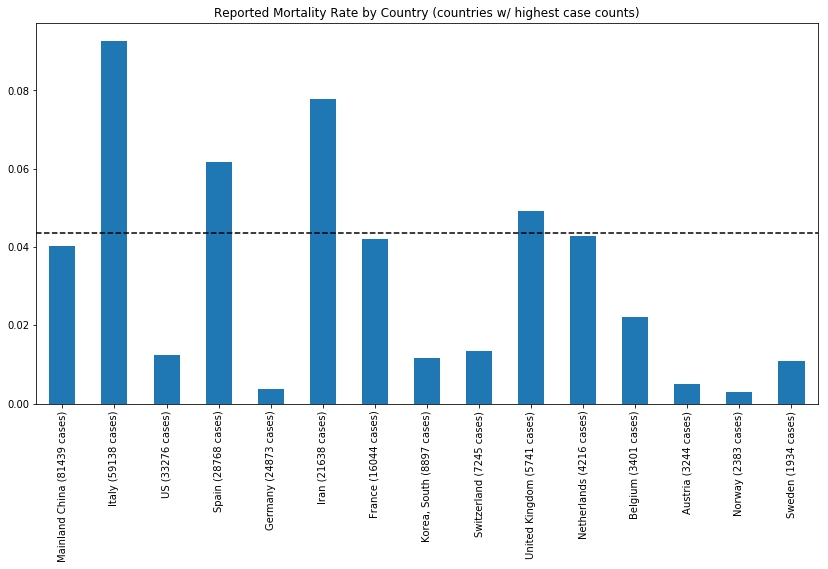

In [26]:

display(Markdown('Data as of %s' % todays_date))

reported_mortality_rate = df['deaths'].sum() / df['cases'].sum()
display(Markdown('Overall reported mortality rate: %.2f%%' % (100.0 * reported_mortality_rate)))

df_highest = df.sort_values('cases', ascending=False).head(15)
mortality_rate = pd.Series(
    data=(df_highest['deaths']/df_highest['cases']).values,
    index=map(lambda x: '%s (%i cases)' % (x, df_highest.loc[x]['cases']),
              df_highest.index))
ax = mortality_rate.plot.bar(
    figsize=(14,7), title='Reported Mortality Rate by Country (countries w/ highest case counts)')
ax.axhline(reported_mortality_rate, color='k', ls='--')

plt.show()